In [1017]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Lorenz system equations
def lorenz(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Initial conditions
initial_xyz = np.array([3, 3, 3])

# Time span
t_span = (0, 35)
# t_eval = np.linspace(t_span[0], t_span[1], 5000)
t_eval = np.arange(t_span[0], t_span[1], 0.01)


np.random.seed(100)

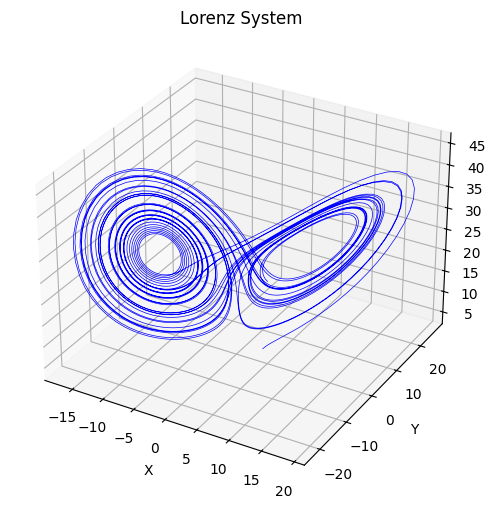

In [1018]:
# Solve the system
sol = solve_ivp(lorenz, t_span, initial_xyz, args=(sigma, rho, beta), t_eval=t_eval)

true_sol = sol.y

# Plot the results
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(true_sol[0], true_sol[1], true_sol[2], 'b-', linewidth=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz System')
plt.show()


## Demo: Sensitive dependence on Initial Condition

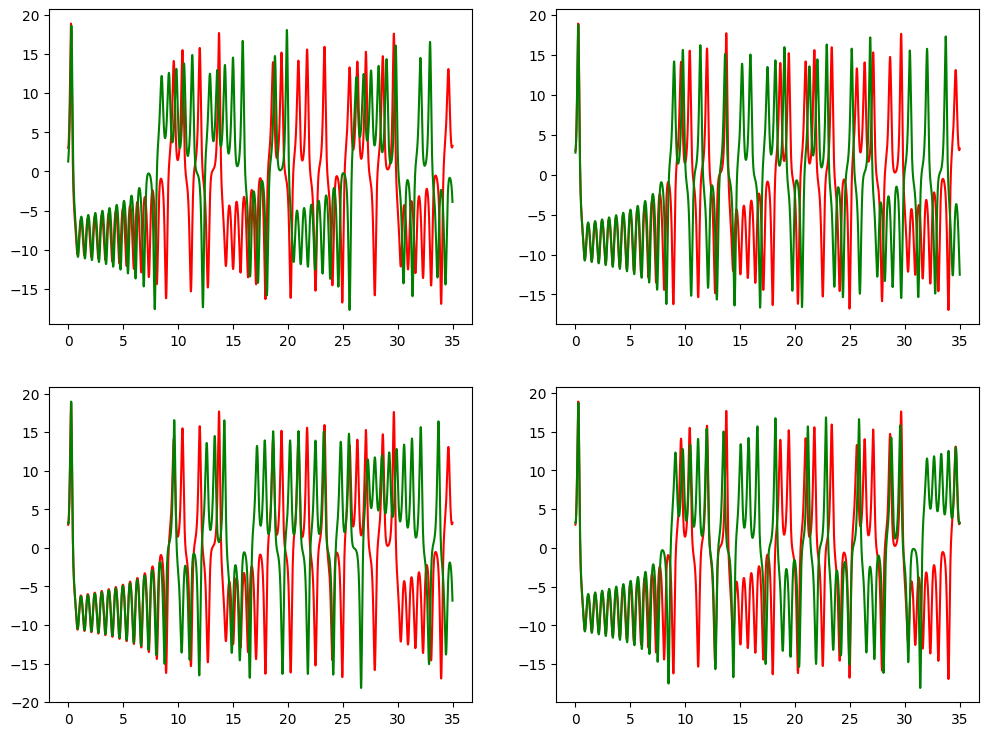

In [1019]:
noise_level = 1

plt.figure(figsize=(12,9))

for j in range(4):
    noisy_initial_xyz = initial_xyz + np.random.normal(0, noise_level, size = (3))

    # Solve the system with noisy IC
    sol = solve_ivp(lorenz, t_span, noisy_initial_xyz, args=(sigma, rho, beta), t_eval=t_eval)

    noisy_sol = sol.y

    plt.subplot(2,2,j+1)
    plt.plot(t_eval, true_sol[0], color='r', label = 'true x(t)')
    plt.plot(t_eval, noisy_sol[0], color='g', label = 'simulated x(t)')
    

## Noisy observation

In [1065]:
# Covariance matrices
Q = np.eye(3) *  0.001 # Process noise covariance
R = np.eye(3) * 4 # Measuremet noise covariance


In [1080]:
measure_width = 100
#Measurement points are spread apart
t_measure = t_eval[::measure_width]

measured_sol = true_sol[:,::measure_width] 
#Adding measurement noise
# measured_sol += np.random.multivariate_normal([0,0,0], R, size = measured_sol[0].shape).transpose()
measured_sol = measured_sol + np.random.multivariate_normal([0,0,0], R, size = measured_sol[0].shape).transpose()


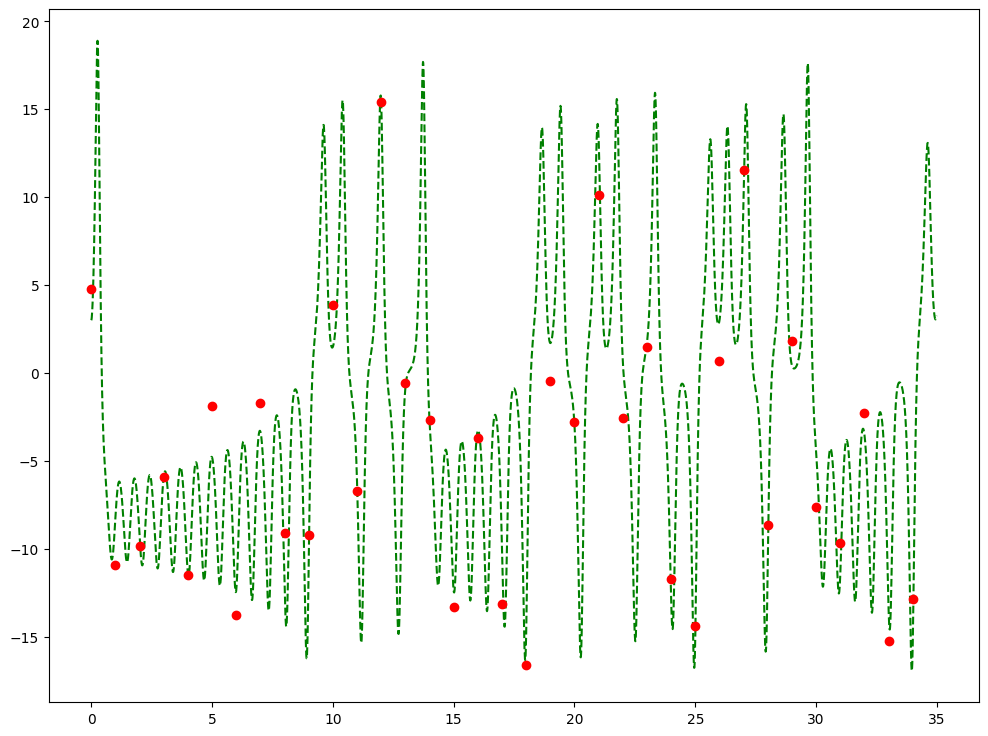

In [1081]:
plt.figure(figsize=(12,9))
plt.plot(t_eval, true_sol[0], c= 'g', ls='--', label = 'true y(t)')
plt.plot(t_measure, measured_sol[0], 'ro', label = 'measured y(t)')

In [1082]:
t_eval[:11]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [1083]:
t_measure[:5]

array([0., 1., 2., 3., 4.])

In [1084]:
np.linspace(0.05, 0.1, 6, endpoint=True)

array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

# DA: Kalman Filtering

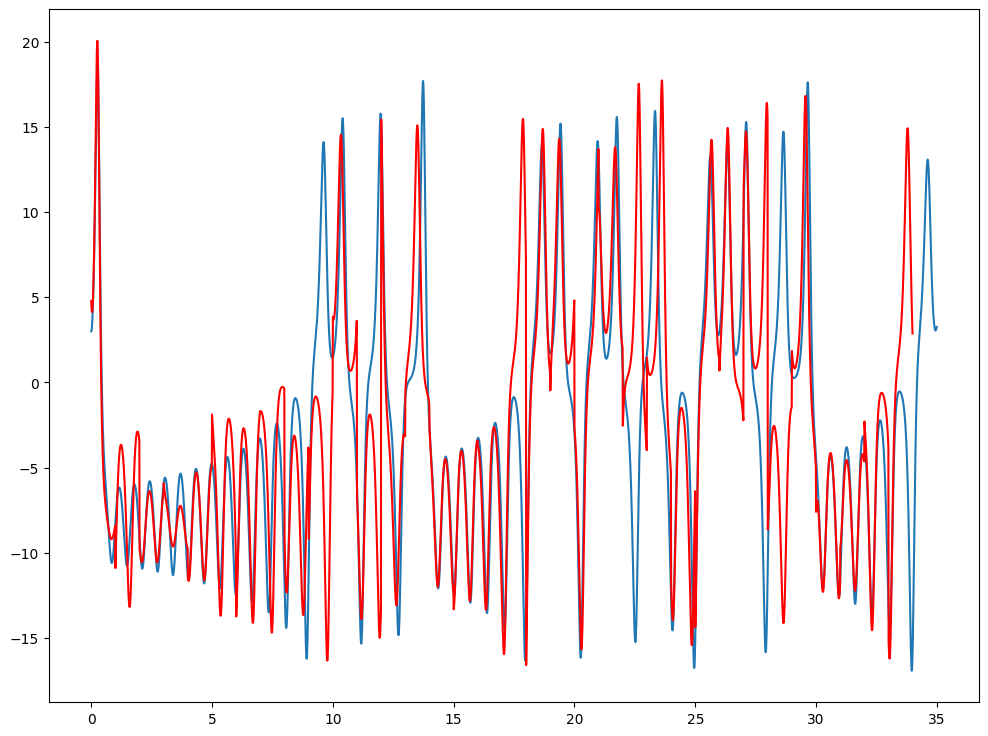

In [1085]:


concat_sol_list = []
t_eval_list = []
for ind in range(len(t_measure)-1):
    t_span = (t_measure[ind], t_measure[ind+1])
    # t_eval_short = np.arange(t_span[0], t_span[1], 0.01)
    t_eval_short = np.linspace(t_span[0], t_span[1], measure_width+1)
    
    # print(t_span)
    # print(t_eval_short)
    sol = solve_ivp(lorenz, t_span, measured_sol[:,ind], args=(sigma, rho, beta), t_eval=t_eval_short)
    # model_error = np.random.multivariate_normal([0,0,0], Q, size = sol.y[0].shape).transpose()
    model_error = 0
    calc_sol = sol.y + model_error
    concat_sol_list.append(calc_sol[:,:-1])

    t_eval_list.append(t_eval_short[:-1])

plt.figure(figsize=(12,9))
plt.plot(t_eval, true_sol[0])
plt.plot(np.concatenate(t_eval_list), np.concatenate(concat_sol_list, axis=1)[0], 'r')

## Using Kalman Gain

In [1086]:
# Define Jacobian of the Lorenz system
def lorenz_jacobian(state, sigma=10, rho=28, beta=8/3):
    x, y, z = state
    return np.array([
        [-sigma, sigma, 0],
        [rho - z, -1, -x],
        [y, x, -beta]
    ])

In [1087]:
def sovler_jac_finder(RHS, t_span, IC, args, t_eval, dx=0.01):
    assert abs(dx) > 1.e-10, "dx value is too small"
    dim = len(IC)
    solver_jac = 0*np.eye(dim)
    for i in range(dim):
        h = np.zeros(dim)
        h[i] = dx
        solver_jac[:,i] = (solve_ivp(RHS, t_span, IC + h, args =args, t_eval=t_eval).y [:,-1] -
                     solve_ivp(RHS, t_span, IC, args =args, t_eval=t_eval).y [:,-1])/dx
    return solver_jac
            

In [1088]:
t_span = (t_measure[ind], t_measure[ind+1])
    # t_eval_short = np.arange(t_span[0], t_span[1], 0.01)
t_eval_short = np.linspace(t_span[0], t_span[1], 2)

print(t_span)
print(t_eval_short)

(33.0, 34.0)
[33. 34.]


In [1089]:
sovler_jac_finder(lorenz, t_span, ic_corrected, args=(sigma, rho, beta), t_eval=t_eval_short)

array([[ 0.39021137,  0.74327229,  0.4790409 ],
       [ 0.48686588,  0.88906162,  0.66426709],
       [-2.44504445, -5.66571055, -1.1542602 ]])

In [1090]:
np.eye(3) + (0.01)*lorenz_jacobian(ic_corrected)

array([[ 0.9       ,  0.1       ,  0.        ],
       [ 0.01885381,  0.99      ,  0.05427512],
       [ 0.03100404, -0.05427512,  0.97333333]])

In [1091]:
y_2 = solve_ivp(lorenz, t_span, ic_corrected+np.array([0.01,0,0]), args=(sigma, rho, beta), t_eval=t_eval_short).y[:,-1]
y_1 = solve_ivp(lorenz, t_span, ic_corrected, args=(sigma, rho, beta), t_eval=t_eval_short).y[:,-1]

(y_2 - y_1)/0.01

array([ 0.39021137,  0.48686588, -2.44504445])

In [1092]:
y_2

array([-2.7888519 , -4.51142783, 16.87913551])

In [1093]:
kalman_sol_list = []
# ic_corrected = measured_sol[:,0]
ic_corrected = true_sol[:,0]

t_eval_list = []

P = R
for ind in range(len(t_measure)-1):
    t_span = (t_measure[ind], t_measure[ind+1])
    # t_eval_short = np.arange(t_span[0], t_span[1], 0.01)
    t_eval_short = np.linspace(t_span[0], t_span[1], measure_width+1)
    
    
    
    sol = solve_ivp(lorenz, t_span, ic_corrected, args=(sigma, rho, beta), t_eval=t_eval_short)
    # model_error = np.random.multivariate_normal([0,0,0], Q, size = sol.y[0].shape).transpose()
    model_error = 0
    calc_sol = sol.y + model_error
    # jacob_prev = lorenz_jacobian(ic_corrected)
    jacob_prev = sovler_jac_finder(lorenz, t_span, ic_corrected, args=(sigma, rho, beta), t_eval=t_eval_short)

    # self.state_covariance = np.dot(np.dot(F, self.state_covariance), F.T) + self.Q
    
    # F = np.eye(len(ic_corrected)) + (t_eval_short[1] - t_eval_short[0]) * jacob_prev
    F = jacob_prev
    P = np.matmul(F, np.matmul(P, F.transpose())) + Q
    # P = np.matmul(F, np.matmul(P, F.transpose())) + Q
    
    # print(np.matmul(F, F.transpose()))
    
    # print(t_span)
    # print(P)
    try:
        K_gain = np.matmul(P, np.linalg.inv(P+R))
    except Exception as e:
        if str(e) == "Singular matrix":
            K_gain = np.eye(3)
        else:
            raise
    
    ic_model = calc_sol[:,-1]
    ic_measured = measured_sol[:,ind+1]
    ic_corrected = ic_model + np.matmul(K_gain, ic_measured - ic_model)
    # print(np.matmul(K_gain, ic_measured - ic_model)

    
    
    kalman_sol_list.append(calc_sol[:,:-1])

    t_eval_list.append(t_eval_short[:-1])


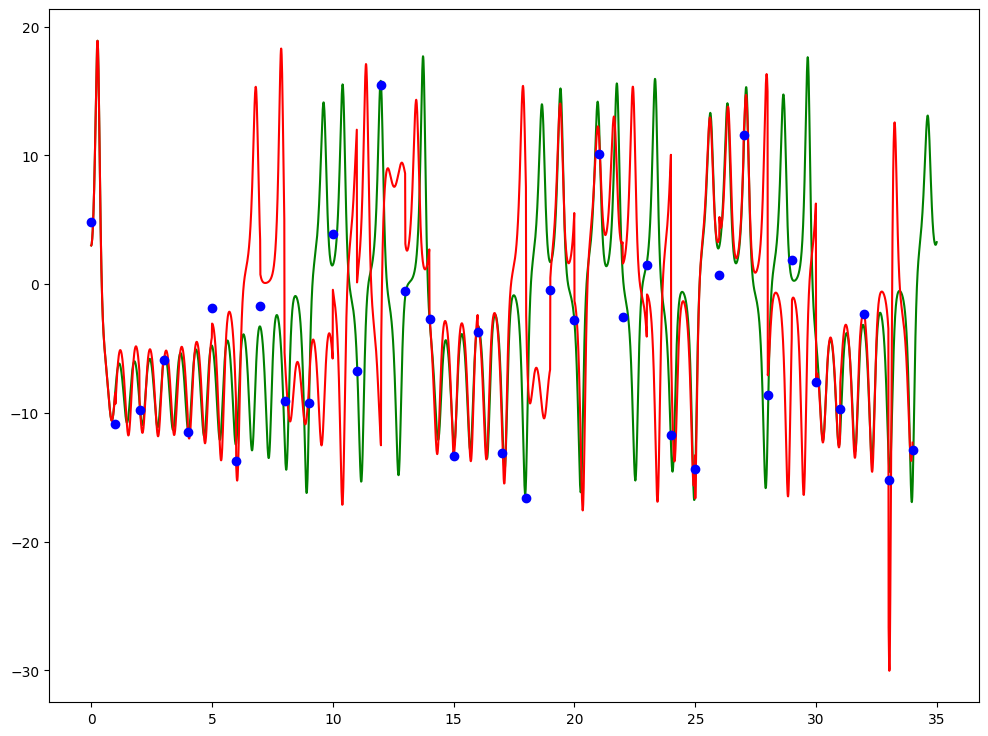

In [1096]:
plt.figure(figsize=(12,9))
plt.plot(t_eval, true_sol[0,:], 'g')
plt.plot(np.concatenate(t_eval_list), np.concatenate(kalman_sol_list, axis=1)[0], 'r-')
plt.plot(t_measure, measured_sol[0], 'bo', label = 'measured y(t)')

# for t_eval_, sol_ in zip(t_eval_list, kalman_sol_list):
#     plt.plot(t_eval_, sol_[1], 'r')

In [371]:
np.matmul(Q, np.linalg.inv(Q+R))

array([[0.45454545, 0.        , 0.        ],
       [0.        , 0.45454545, 0.        ],
       [0.        , 0.        , 0.45454545]])

In [98]:
import numpy as np
import matplotlib.pyplot as plt

# Lorenz system equations
def lorenz(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt])

# Define the measurement function (identity matrix, as we directly measure the state)
H = np.eye(3)

# Covariance matrices
Q = np.eye(3) * 2.0  # Process noise covariance
R = np.eye(3) * 5.0   # Measurement noise covariance

# Kalman filter initialization
x_hat = np.array([1.0, 1.0, 1.0])  # Initial state estimate
P = np.eye(3) * 0.1                # Initial covariance estimate

# Parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Time span
dt = 0.01
t_span = np.arange(0, 50, dt)

# True state (simulate the Lorenz system)
true_states = np.zeros((len(t_span), 3))
true_states[0] = x_hat
for i in range(1, len(t_span)):
    true_states[i] = true_states[i - 1] + lorenz(t_span[i - 1], true_states[i - 1], sigma, rho, beta) * dt

noisy_states = true_states + np.random.multivariate_normal([0,0,0], Q)

In [99]:
measurement

(5000, 3)

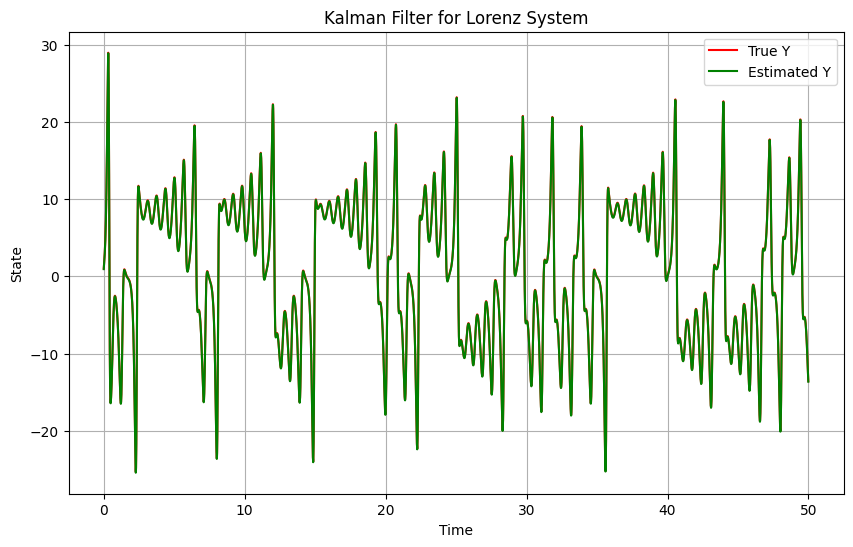

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Lorenz system equations
def lorenz(t, xyz, sigma, rho, beta):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return np.array([dxdt, dydt, dzdt])

# Define the measurement function (identity matrix, as we directly measure the state)
H = np.eye(3)

# Covariance matrices
Q = np.eye(3) * 2.0  # Process noise covariance
R = np.eye(3) * 5.0   # Measurement noise covariance

# Kalman filter initialization
x_hat = np.array([1.0, 1.0, 1.0])  # Initial state estimate
P = np.eye(3) * 0.1                # Initial covariance estimate

# Parameters
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

# Time span
dt = 0.01
t_span = np.arange(0, 50, dt)

# True state (simulate the Lorenz system)
true_states = np.zeros((len(t_span), 3))
true_states[0] = x_hat
for i in range(1, len(t_span)):
    true_states[i] = true_states[i - 1] + lorenz(t_span[i - 1], true_states[i - 1], sigma, rho, beta) * dt

noisy_states = true_states + np.random.multivariate_normal([0,0,0], Q)
# Kalman filter loop
estimated_states = np.zeros((len(t_span), 3))
for i in range(len(t_span)):
    # Prediction step
    # x_hat_minus = true_states[i]  # As the Lorenz system is our true system
    x_hat_minus = noisy_states[i]  # As the Lorenz system is our true system
    
    P_minus = P + Q

    # Update step (we simulate the measurement noise here)
    measurement = true_states[i] + np.random.multivariate_normal([0, 0, 0], R)
    # measurement = noisy_states[i] + np.random.multivariate_normal([0, 0, 0], R)
    
    # print(true_states[i] - measurement)
    # K = P_minus.dot(H.T).dot(np.linalg.inv(H.dot(P_minus).dot(H.T) + R))
    K = P_minus.dot(H.T).dot(np.linalg.inv(H.dot(P_minus).dot(H.T) + R))
    
    x_hat = x_hat_minus + K.dot(measurement - H.dot(x_hat_minus))
    x_hat = x_hat_minus
    
    P = (np.eye(3) - K.dot(H)).dot(P_minus)

    estimated_states[i] = x_hat

# Plot the results
plt.figure(figsize=(10, 6))
# plt.plot(t_span, true_states[:, 0], 'b-', label='True X')
plt.plot(t_span, true_states[:, 1], 'r', label='True Y')
# plt.plot(t_span, true_states[:, 2], 'r-', label='True Z')
# plt.plot(t_span, estimated_states[:, 0], 'b--', label='Estimated X')
plt.plot(t_span, estimated_states[:, 1], 'g', label='Estimated Y')

# plt.plot(t_span, estimated_states[:, 2], 'r--', label='Estimated Z')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Kalman Filter for Lorenz System')
plt.legend()
plt.grid(True)
plt.show()

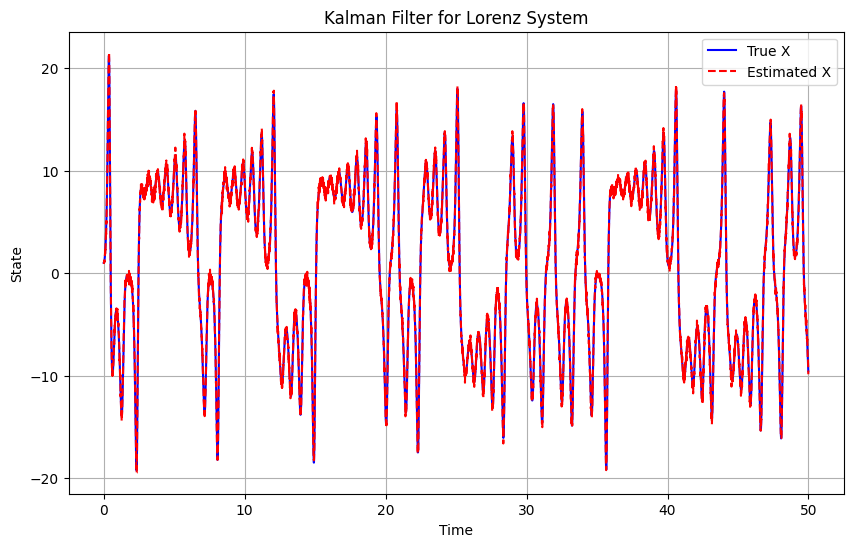

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_span, true_states[:, 0], 'b-', label='True X')
# plt.plot(t_span, true_states[:, 1], 'g-', label='True Y')
# plt.plot(t_span, true_states[:, 2], 'r-', label='True Z')
plt.plot(t_span, estimated_states[:, 0], 'r--', label='Estimated X')
# plt.plot(t_span, estimated_states[:, 1], 'g--', label='Estimated Y')
# plt.plot(t_span, estimated_states[:, 2], 'r--', label='Estimated Z')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Kalman Filter for Lorenz System')
plt.legend()
plt.grid(True)
plt.show()